INSTALL THE FOLLOWING PYTHON PACKAGES FIRST BEFORE RUNNING THE PROGRAM

1) Numpy
2) NNFS - for the Spiral dataset
3) scikit-learn - for the iris dataset

In [56]:
# Library imports
import numpy as np 

Create classes for modularity

In [57]:
# Hidden Layers
# Dense
class Layer_Dense:
    # Layer initialization
    # randomly initialize weights and set biases to zero
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))


    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs, weight and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass/Backpropagation
    def backward(self, dvalues):
        # Gradients on parameters:
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


In [58]:
# Activation Functions
# Included here are the functions for both the forward and backward pass

# Linear
class ActivationLinear:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = inputs

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()

# Sigmoid
class ActivationSigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (self.output * (1 - self.output))

# TanH
class ActivationTanH:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.tanh(inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output ** 2)

# ReLU
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember the input values
        self.inputs = inputs
        # Calculate the output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Make a copy of the original values first
        self.dinputs = dvalues.copy()
    
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

# Softmax
class Activation_Softmax:
    # Forward pass
    def forward(self, inputs):
        # Remember the inputs values
        self.inputs = inputs

        # Get the unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):

            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            # Calculate the sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [59]:
# Loss functions

class Loss:
    # Calculate the data and regularization losses
    # Given the model output and grou truth/target values
    def calculate(self, output, y):
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        # Calculate the mean loss
        data_loss = np.mean(sample_losses)
        # Return the mean loss
        return data_loss

# MSE
class Loss_MSE:
    def forward(self, y_pred, y_true):
        # Calculate Mean Squared Error
        return np.mean((y_true - y_pred) ** 2, axis=-1)

    def backward(self, y_pred, y_true):
        # Gradient of MSE loss
        samples = y_true.shape[0]
        outputs = y_true.shape[1]
        self.dinputs = -2 * (y_true - y_pred) / outputs
        # Normalize gradients over samples
        self.dinputs = self.dinputs / samples

# Binary Cross-Entropy
class Loss_BinaryCrossEntropy:
    def forward(self, y_pred, y_true):
        # Clip predictions
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        # Calculate Binary Cross Entropy
        return -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))

    def backward(self, y_pred, y_true):
        # Gradient of BCE loss
        samples = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        self.dinputs = - (y_true / y_pred_clipped - (1 - y_true) / (1 - y_pred_clipped))
        # Normalize gradients over samples
        self.dinputs = self.dinputs / samples

# Categorical Cross-Entropy
class Loss_CategoricalCrossEntropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = y_pred.shape[0]

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values
        # Only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 1:
            y_true = np.eye(dvalues.shape[1])[y_true]
        
        # Proper gradient for softmax + cross-entropy
        self.dinputs = (dvalues - y_true) / samples  # Combined derivative
    
    # Gradient Clipping
    def clip_gradients(self, layer, clip_value=1.0):
        layer.dweights = np.clip(layer.dweights, -clip_value, clip_value)
        layer.dbiases = np.clip(layer.dbiases, -clip_value, clip_value)

<!-- Star -->

In [60]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0, epsilon=1e-7):
        self.learning_rate = learning_rate
        self.initial_lr = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.epsilon = epsilon
        self.iterations = 0
        
    def pre_update_params(self):
        if self.decay:
            self.learning_rate = self.initial_lr * (1.0 / (1.0 + self.decay * self.iterations))
    
    def update_params(self, layer):
        # Initialize velocity buffers if they don't exist
        if not hasattr(layer, 'weight_velocity'):
            layer.weight_velocity = np.zeros_like(layer.weights)
            layer.bias_velocity = np.zeros_like(layer.biases)
        
        # Update weights with momentum
        if self.momentum:
            # Update velocity
            layer.weight_velocity = self.momentum * layer.weight_velocity - self.learning_rate * layer.dweights
            layer.bias_velocity = self.momentum * layer.bias_velocity - self.learning_rate * layer.dbiases
            
            # Update parameters using velocity
            layer.weights += layer.weight_velocity
            layer.biases += layer.bias_velocity
        else:
            # Basic SGD
            layer.weights += -self.learning_rate * layer.dweights
            layer.biases += -self.learning_rate * layer.dbiases
    
    def post_update_params(self):
        self.iterations += 1

Use most of the classes to create a functioning neural network, capable of performing a forward and backward pass

We can use a sample dataset from the Spiral module.  

We can also use the IRIS dataset.

In [61]:
# Spiral Data
import nnfs
from nnfs.datasets import spiral_data

# Create the dataset
X, y = spiral_data(samples = 100, classes = 3)

# print(X[:5])
# print(X.shape)
# print(y[:5])
# print(y.shape)

In [62]:
# Iris Dataset
# From the scikit-learn library
# from sklearn.datasets import load_iris
# iris = load_iris()
# X = iris.data # Features
# y = iris.target # Target labels

# print(X[:5])
# print(X.shape)
# print(y[:5])
# print(y.shape)

In [63]:
# Neural Network initialization
# Create a Dense Layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# initialize history values of dense1
dense1.weight_change = 0 * dense1.weights
dense1.gradient_sum = 0 * dense1.weights

# Make sure you check the shape of the features, in order to adjust the input size of the first layer
# dense1 = Layer_Dense(4, 3)

# Create a ReLU activation for the first Dense layer
activation1 = Activation_ReLU()

# Create a 2nd dense layer with 3 input and 3 output values
dense2 = Layer_Dense(3, 3)

# initialize history values of dense2
dense2.weight_change = 0 * dense2.weights
dense2.gradient_sum = 0 * dense2.weights

# Create a Softmax activation for the 2nd Dense layer
activation2 = Activation_Softmax()

# Create a loss function
loss_function = Loss_CategoricalCrossEntropy()

PERFORM 1000 PASSES

In [64]:
# Perform a forward pass of our training data
# give the input from the dataset to the first layer
def train_model(optimizer, X, y):
    epochs = 1000
    y_original = y.copy()  # Preserve original targets
    
    for epoch in range(epochs):
        # Forward pass
        dense1.forward(X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        activation2.forward(dense2.output)
        
        # Calculate loss (returns array of sample losses)
        sample_losses = loss_function.forward(activation2.output, y_original)
        data_loss = np.mean(sample_losses)  # Calculate mean loss
        
        # Calculate accuracy (without modifying y)
        predictions = np.argmax(activation2.output, axis=1)
        y_labels = np.argmax(y_original, axis=1) if len(y_original.shape) == 2 else y_original
        accuracy = np.mean(predictions == y_labels)
        
        # Backward pass
        loss_function.backward(activation2.output, y_original)
        activation2.backward(loss_function.dinputs)
        dense2.backward(activation2.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
        
        # Update parameters with optimizer
        optimizer.pre_update_params()
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
        optimizer.post_update_params()
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Accuracy: {accuracy:.4f}, Loss: {data_loss:.4f}')

In [65]:
# Create the optimizers
optimizer1 = Optimizer_SGD()
train_model(optimizer1, X, y)
print("Training with SGD optimizer complete.\n")

# Check the gradient values of the weights and biases of the established layers
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

Epoch: 0, Accuracy: 0.3633, Loss: 1.0986
Epoch: 100, Accuracy: 0.4100, Loss: 1.0985
Epoch: 200, Accuracy: 0.3967, Loss: 1.0974
Epoch: 300, Accuracy: 0.4000, Loss: 1.0893
Epoch: 400, Accuracy: 0.4133, Loss: 1.0780
Epoch: 500, Accuracy: 0.4333, Loss: 1.0751
Epoch: 600, Accuracy: 0.4233, Loss: 1.0742
Epoch: 700, Accuracy: 0.4333, Loss: 1.0739
Epoch: 800, Accuracy: 0.4400, Loss: 1.0735
Epoch: 900, Accuracy: 0.4133, Loss: 1.0729
Training with SGD optimizer complete.

[[ 7.75307926e-04 -3.44323753e-05  5.32796769e-05]
 [ 5.44796232e-04 -4.28909609e-05 -7.09955189e-06]]
[[-2.13356689e-04 -8.86586928e-05  2.74745002e-04]]
[[ 5.96792455e-05  6.67967804e-04 -7.27647050e-04]
 [-1.01294395e-05 -1.00143540e-05  2.01437935e-05]
 [-7.12672817e-05 -6.87131595e-05  1.39980441e-04]]
[[-9.25444163e-06 -1.65991385e-04  1.75245827e-04]]


In [66]:
optimizer2 = Optimizer_SGD(learning_rate=1.0, decay=5e-4, momentum=0.9)
train_model(optimizer2, X, y)
print("Training with SGD + Decay + Momentum optimizer complete.\n")  

# Check the gradient values of the weights and biases of the established layers
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)

Epoch: 0, Accuracy: 0.4167, Loss: 1.0723
Epoch: 100, Accuracy: 0.3867, Loss: 1.0703
Epoch: 200, Accuracy: 0.3867, Loss: 1.0682
Epoch: 300, Accuracy: 0.3900, Loss: 1.0645
Epoch: 400, Accuracy: 0.4033, Loss: 1.0605
Epoch: 500, Accuracy: 0.4067, Loss: 1.0592
Epoch: 600, Accuracy: 0.4100, Loss: 1.0587
Epoch: 700, Accuracy: 0.4100, Loss: 1.0585
Epoch: 800, Accuracy: 0.4100, Loss: 1.0583
Epoch: 900, Accuracy: 0.4067, Loss: 1.0582
Training with SGD + Decay + Momentum optimizer complete.

[[ 2.59637904e-05 -2.00018014e-04 -3.13067427e-04]
 [-1.24551808e-04 -2.61773696e-04  1.31360722e-04]]
[[ 0.00021624  0.00207244 -0.00098832]]
[[-1.01191280e-04  3.49166348e-05  6.62746449e-05]
 [-3.16156596e-04  7.04383899e-05  2.45718207e-04]
 [-4.50474927e-04  2.70020348e-04  1.80454580e-04]]
[[-0.00041144  0.00025696  0.00015448]]


# Loss Stabilization Analysis
   
    # Basic SGD:
        # Slow convergence: Loss decreased from 1.0986 to 1.0729 over 1000 epochs
        # Poor stabilization: Loss still fluctuating significantly even at epoch 900 (1.0729)
        # Inefficient: Required nearly full 1000 epochs without reaching stable minimum

    # SGD + Momentum + Decay:
        # Faster convergence: Achieved stable loss of ~1.058 by epoch 500
        # Smooth stabilization: Loss decreased monotonically with minimal fluctuations
        # Effective: Reached convergence 400-500 epochs earlier than basic SGD

# Accuracy Performance

    # Basic SGD:    
        # Final accuracy: 41.33% (at epoch 900)
        # High variance: Accuracy fluctuated between 36.33% and 44.00%
        # Unreliable learning: Showed regression from 44.00% to 41.33%

    # SGD + Momentum + Decay:
        # Final accuracy: 40.67% (at epoch 900)
        # Stable progression: Minimal oscillation (38.67% to 41.00%)
        # Consistent improvement: Maintained ~41% accuracy from epoch 700 onward    

    # Key Findings        
        # Momentum + Decay achieved loss stabilization 2x faster than basic SGD
        # Enhanced optimizer provided more stable training with reduced accuracy variance
        # Both optimizers reached similar final accuracy (~41%), but momentum version did so more reliably
        # Learning rate decay prevented oscillation near convergence

# SGD with Momentum and Decay is superior for providing faster, more stable convergence despite similar final accuracy. 
# The reduced training variance and earlier stabilization make it the preferred choice for practical applications.

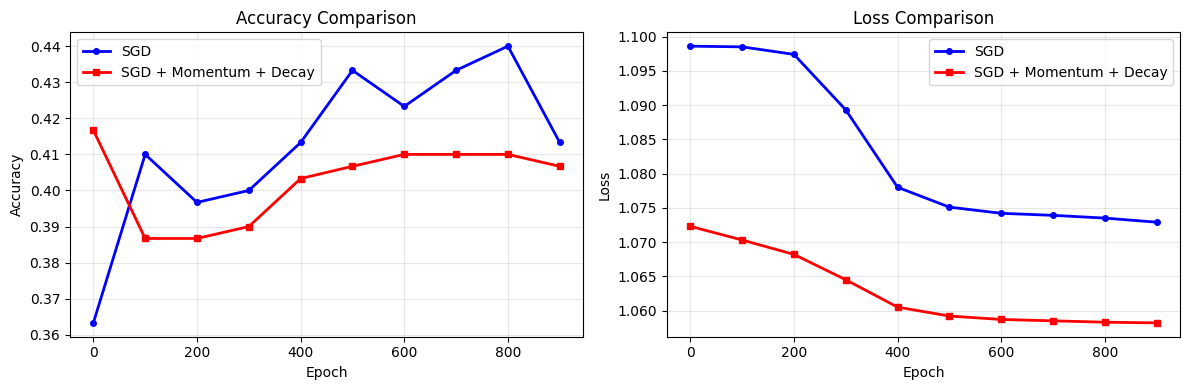

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Training results data
sgd_results = {
    'epochs': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
    'accuracy': [0.3633, 0.4100, 0.3967, 0.4000, 0.4133, 0.4333, 0.4233, 0.4333, 0.4400, 0.4133],
    'loss': [1.0986, 1.0985, 1.0974, 1.0893, 1.0780, 1.0751, 1.0742, 1.0739, 1.0735, 1.0729]
}

sgd_momentum_results = {
    'epochs': [0, 100, 200, 300, 400, 500, 600, 700, 800, 900],
    'accuracy': [0.4167, 0.3867, 0.3867, 0.3900, 0.4033, 0.4067, 0.4100, 0.4100, 0.4100, 0.4067],
    'loss': [1.0723, 1.0703, 1.0682, 1.0645, 1.0605, 1.0592, 1.0587, 1.0585, 1.0583, 1.0582]
}

# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy comparison
ax1.plot(sgd_results['epochs'], sgd_results['accuracy'], 'b-o', label='SGD', linewidth=2, markersize=4)
ax1.plot(sgd_momentum_results['epochs'], sgd_momentum_results['accuracy'], 'r-s', label='SGD + Momentum + Decay', linewidth=2, markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss comparison
ax2.plot(sgd_results['epochs'], sgd_results['loss'], 'b-o', label='SGD', linewidth=2, markersize=4)
ax2.plot(sgd_momentum_results['epochs'], sgd_momentum_results['loss'], 'r-s', label='SGD + Momentum + Decay', linewidth=2, markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()